In [5]:
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [6]:
# load the data
file_url = "https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv"
data = pd.read_csv(file_url)
data.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


In [7]:
# data preparpation
# select column and lower case their names
relevant_features=['Make', 'Model', 'Year', 'Engine HP', 'Engine Cylinders', 'Transmission Type', 'Vehicle Style','highway MPG', 'city mpg', 'MSRP']
data = data[relevant_features].copy()
data.columns = data.columns.str.replace(' ', '_').str.lower()

# fill missing values with 0
data = data.fillna(0).copy()

# rename 'msrp' to 'price'
data = data.rename(columns={'msrp':'price'}).copy()

data.head()

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,price
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500


### Question 1

In [8]:
# most frequent observation for column transmission_type
data.transmission_type.value_counts()

transmission_type
AUTOMATIC           8266
MANUAL              2935
AUTOMATED_MANUAL     626
DIRECT_DRIVE          68
UNKNOWN               19
Name: count, dtype: int64

### Question 2

In [9]:
# create the correlation matrix for the numerical features
corr_matrix = data[data.columns[data.dtypes!='object'].tolist()].corr()
corr_matrix

,year,engine_hp,engine_cylinders,highway_mpg,city_mpg,price
year,1.000000,0.338714,-0.040708,0.258240,0.198171,0.227590
engine_hp,0.338714,1.000000,0.774851,-0.415707,-0.424918,0.650095
engine_cylinders,-0.040708,0.774851,1.000000,-0.614541,-0.587306,0.526274
highway_mpg,0.258240,-0.415707,-0.614541,1.000000,0.886829,-0.160043
city_mpg,0.198171,-0.424918,-0.587306,0.886829,1.000000,-0.157676
price,0.227590,0.650095,0.526274,-0.160043,-0.157676,1.000000


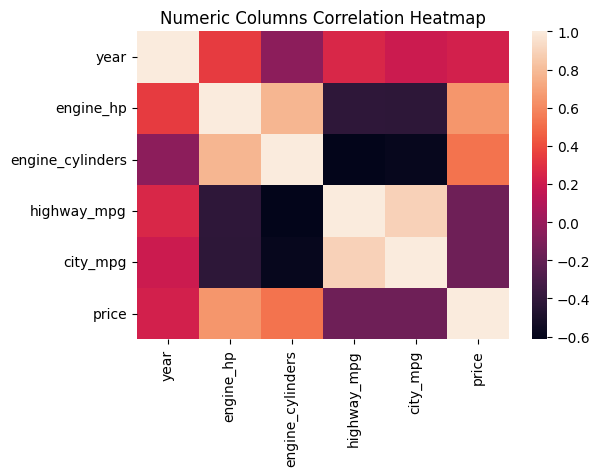

In [10]:
plt.figure(figsize=(6,4))
sns.heatmap(corr_matrix)
plt.title('Numeric Columns Correlation Heatmap')
plt.show()

In [11]:
corr_matrix.unstack().sort_values(ascending=False)[corr_matrix.unstack()!=1][:5]

city_mpg          highway_mpg         0.886829
highway_mpg       city_mpg            0.886829
engine_hp         engine_cylinders    0.774851
engine_cylinders  engine_hp           0.774851
price             engine_hp           0.650095
dtype: float64

In [12]:
# make price binary
df = data.copy()
df['above_average'] = (df.price > df.price.mean()).astype(int)
df = df.drop(['price'], axis=1)
df.head()

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,above_average
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,1
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,1
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,0
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,0
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,0


In [13]:
# split the data into train/val/test with 60%/20%/20%
df_full_train, df_test = train_test_split(df, test_size=round(len(df)*.2), random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=round(len(df)*.2), random_state=42)

In [14]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train['above_average'].values
y_val = df_val['above_average'].values
y_test = df_test['above_average'].values

del df_train['above_average']
del df_val['above_average']
del df_test['above_average']

### Question 3

In [15]:
# calculate the mutual information score between above_average and other categorical variables 
cat = df_train.columns[df_train.dtypes=='object'].tolist()
num = df_train.columns[df_train.dtypes!='object'].tolist()

In [16]:
lowest_mutual_score = min([mutual_info_score(y_train, df_train[c]) for c in cat])

[c for c in cat if mutual_info_score(y_train, df_train[c])==lowest_mutual_score]

['transmission_type']

### Question 4

In [17]:
# one-hot encode features
def one_hot_encode(train_df, test_df, features):
    train_dict=train_df[features].to_dict(orient='records')
    val_dict=test_df[features].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    dv.fit(train_dict)
        
    return dv.transform(train_dict), dv.transform(val_dict)

In [18]:
# train and run logistic regression model
def train_run_logistic_regression(X_train, y_train, X_test, y_test):
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    
    return (y_pred==y_test).mean()

In [19]:
# one-hot encode categorical variables
features = cat+num
X_train, X_val = one_hot_encode(df_train, df_val, features)

In [21]:
# train logistic regression model
accuracy = train_run_logistic_regression(X_train, y_train, X_val, y_val)
print(round(accuracy,2))

0.94


### Question 5

In [17]:
score_differences = []
for c in features:
    subset = features.copy()
    subset.remove(c)

    X_train, X_val = one_hot_encode(df_train, df_val, subset)
    score = train_run_logistic_regression(X_train, y_train, X_val, y_val)

    score_differences.append(np.abs(accuracy - score))

min(dict(zip(features, score_differences)))

'city_mpg'

### Question 6

In [18]:
data.price = np.log1p(data.price)

In [19]:
# split and prepare the data
df_train_full, df_test = train_test_split(data, test_size=round(len(data)*.2), random_state=42)
df_train, df_val = train_test_split(df_train_full, test_size=round(len(data)*.2), random_state=42)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.price.values
y_val = df_val.price.values
y_test = df_test.price.values

del df_train['price']
del df_val['price']
del df_test['price']

In [20]:
def train_run_ridge_regression(X_train, y_train, X_test, y_test, a):
    model = Ridge(alpha=a, solver="sag", random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    return np.sqrt(mean_squared_error(y_test, y_pred))

In [21]:
# ridge regression 
X_train, X_val = one_hot_encode(df_train, df_val, df_train.columns)

alphas = [0, 0.01, 0.1, 1, 10]
scores = [train_run_ridge_regression(X_train, y_train, X_val, y_val, a) for a in alphas]

/home/minasonbol/Documents/study/mleng-zoomcamp/env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/minasonbol/Documents/study/mleng-zoomcamp/env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/minasonbol/Documents/study/mleng-zoomcamp/env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/minasonbol/Documents/study/mleng-zoomcamp/env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/minasonbol/Documents/study/mleng-zoomcamp/env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: T

In [22]:
min(dict(zip(list(map(str,alphas)), scores)))

'0'